In [1]:
    from google.colab import drive
    drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
cd UOC/comp vision/

/content/drive/MyDrive/UOC/comp vision


In [4]:
cd styles/

/content/drive/MyDrive/UOC/comp vision/styles


In [5]:
ls

child.jpeg                pretrained_style_transfer_model/
cubism.webp               simple_cnn_output.jpg
fast_stylized_output.jpg  style_model.zip
pic1.jpeg                 style_transfer_final.tflite
pic2convert.jpeg          style_transfer_fixed.tflite
pic2.webp                 style_transfer_frozen_model/
pic3.jpg                  style_transfer_imagenet/
pic4.png                  style_transfer_model/
pic5.jpg                  style_transfer_model_fixed/
pic6.jpg                  style_transfer_model_fixed.tflite
pic7.jpeg                 style_transfer_quantized_imagenet/
pic8.webp                 style_transfer_quantized_imagenet.tflite
pic9.jpg                  style_transfer_quantized.tflite
picart.jpg                stylized_output.jpg


## IMPORTS

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import lpips
import torch
import torchvision.transforms as T
from PIL import Image

## IMAGE UTILITIES

In [6]:
def preprocess_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB
    return np.clip(x / 255.0, 0, 1)

def gram_matrix(tensor):
    x = tf.transpose(tensor, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

content_path = 'child.jpeg'
style_path = 'cubism.webp'

content_image = preprocess_image(content_path)
style_image = preprocess_image(style_path)
generated_image = tf.Variable(content_image, dtype=tf.float32)

In [7]:
# Load VGG19 for feature extraction
vgg = vgg19.VGG19(weights='imagenet', include_top=False)
vgg.trainable = False

content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

#feature extraction
outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
model = Model(inputs=vgg.input, outputs=outputs)
model.trainable = False

#loss func
def compute_loss(generated, style, content):
    generated_outputs = model(generated)
    style_outputs = model(style)
    content_outputs = model(content)

    # Style loss
    style_loss = 0
    for gen, sty in zip(generated_outputs[:5], style_outputs[:5]):
        gram_gen = gram_matrix(gen[0])
        gram_style = gram_matrix(sty[0])
        style_loss += tf.reduce_mean(tf.square(gram_gen - gram_style))

    # Content loss
    content_loss = tf.reduce_mean(tf.square(generated_outputs[5][0] - content_outputs[5][0]))

    total_loss = 1e-2 * style_loss + content_loss
    return total_loss


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
opt = tf.optimizers.Adam(learning_rate=5.0)

@tf.function()
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, style_image, content_image)
    grad = tape.gradient(loss, generated_image)
    opt.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, -128.0, 128.0))

# Train the model
epochs = 1000
for i in range(epochs):
    train_step()
    print(f"Iteration {i} completed")


Iteration 0 completed
Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Iteration 4 completed
Iteration 5 completed
Iteration 6 completed
Iteration 7 completed
Iteration 8 completed
Iteration 9 completed
Iteration 10 completed
Iteration 11 completed
Iteration 12 completed
Iteration 13 completed
Iteration 14 completed
Iteration 15 completed
Iteration 16 completed
Iteration 17 completed
Iteration 18 completed
Iteration 19 completed
Iteration 20 completed
Iteration 21 completed
Iteration 22 completed
Iteration 23 completed
Iteration 24 completed
Iteration 25 completed
Iteration 26 completed
Iteration 27 completed
Iteration 28 completed
Iteration 29 completed
Iteration 30 completed
Iteration 31 completed
Iteration 32 completed
Iteration 33 completed
Iteration 34 completed
Iteration 35 completed
Iteration 36 completed
Iteration 37 completed
Iteration 38 completed
Iteration 39 completed
Iteration 40 completed
Iteration 41 completed
Iteration 42 completed
Iteration 43 complete

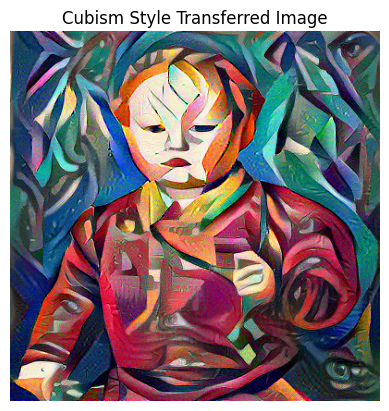

In [9]:
# Display and save stylized output
output = deprocess_image(generated_image.numpy())
plt.imshow(output)
plt.axis('off')
plt.title('Cubism Style Transferred Image')
plt.show()


In [35]:

# LPIPS Evaluation for VGG-based Output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_model = lpips.LPIPS(net='alex').to(device)

def load_lpips_image(img_path, target_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    img = Image.open(img_path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

img1 = load_lpips_image('child.jpeg')
img2 = load_lpips_image('stylized_output.jpg')

with torch.no_grad():
    score_vgg = lpips_model(img1, img2)

print(f"LPIPS (Custom VGG Transfer): {score_vgg.item():.4f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS(Content vs Stylized): 0.8092


# <b> FAST STYLE TRANSFER (TF Hub)

In [23]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the model from TensorFlow Hub
model_url = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_model = hub.load(model_url)

tf.saved_model.save(hub_model, "pretrained_style_transfer_model")

import shutil
shutil.make_archive("style_model", 'zip', "pretrained_style_transfer_model")

from google.colab import files
files.download("style_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import numpy as np
from PIL import Image
import tensorflow as tf

def load_image_pil(path_to_img, max_dim=512):
    img = Image.open(path_to_img).convert('RGB')
    img = np.array(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (max_dim, max_dim))
    img = img[tf.newaxis, :] / 255.0
    return img


In [28]:
content_image = load_image_pil('child.jpeg')
style_image = load_image_pil('cubism.webp')


In [29]:
stylized_image = hub_model(content_image, style_image)[0]


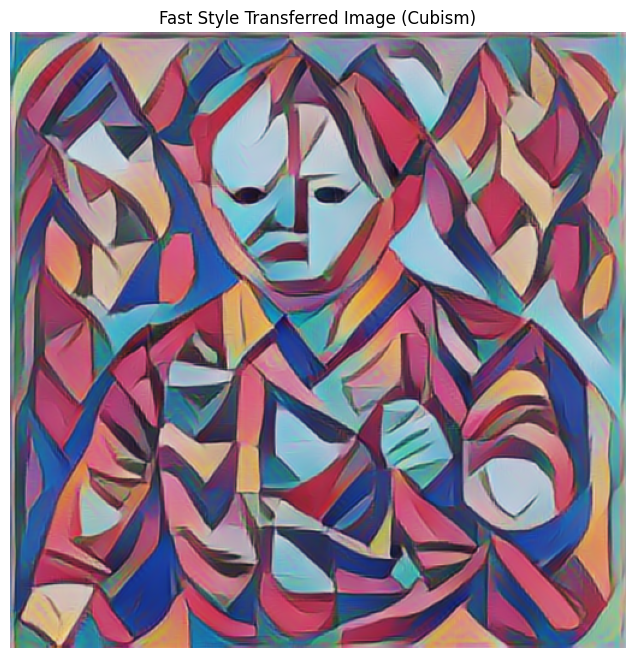

In [30]:
plt.figure(figsize=(8, 8))
plt.imshow(tf.squeeze(stylized_image))
plt.axis('off')
plt.title("Fast Style Transferred Image (Cubism)")
plt.show()


In [31]:
import torchvision.transforms as transforms
from PIL import Image
import torch

def load_lpips_image(image_path, target_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),  # Converts to [0,1]
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # [-1, 1] for LPIPS
    ])
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    return img

lpips_model = lpips.LPIPS(net='alex')



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [32]:
# LPIPS Evaluation for Fast Transfer
output_img = tensor_to_image(stylized_image)
output_img.save('fast_stylized_output.jpg')


img1 = load_lpips_image('child.jpeg')
img2 = load_lpips_image('fast_stylized_output.jpg')

with torch.no_grad():
    lpips_score = lpips_model(img1, img2)

print(f"LPIPS Score (Content vs Fast Stylized): {lpips_score.item():.4f}")


LPIPS Score (Content vs Fast Stylized): 0.6691
